In [2]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import pandas as pd
import csv
import time
from igraph import *
import cairocffi
import cairo

In [3]:
with open('Highschool_network_edge.csv') as csvfile:
    reader = csv.reader(csvfile)
    edges = [(int(row[0][1:]), int(row[1][1:])) for row in reader]

NodeID = []
Gender = []
Hall = []
Threshold = []

with open('Highschool_network_att.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        NodeID.append(int(row[0][1:]))
        Gender.append(row[1])
        Hall.append(row[2])
        Threshold.append(row[3])

g = Graph (edges, directed=False)
g.vs["NodeID"] = NodeID
g.vs["Gender"] = Gender
g.vs["Hall"] = Hall
g.vs["Threshold"] = Threshold

[(1, 10), (1, 20), (1, 27), (1, 31), (1, 39), (1, 54), (1, 78), (1, 102), (1, 110), (1, 112), (2, 4), (2, 27), (2, 54), (2, 64), (2, 95), (2, 111), (3, 12), (3, 32), (3, 58), (4, 27), (4, 37), (4, 38), (4, 58), (4, 61), (4, 64), (4, 66), (4, 68), (4, 77), (4, 83), (5, 67), (5, 92), (5, 103), (5, 113), (6, 28), (6, 37), (6, 55), (6, 80), (6, 107), (7, 9), (7, 15), (7, 59), (7, 63), (7, 79), (7, 88), (7, 95), (7, 99), (8, 20), (8, 35), (8, 51), (8, 53), (8, 61), (9, 15), (9, 75), (9, 79), (9, 102), (10, 31), (10, 39), (10, 50), (10, 54), (10, 102), (10, 106), (10, 110), (10, 112), (11, 103), (12, 24), (12, 32), (13, 19), (13, 25), (13, 46), (13, 65), (13, 69), (14, 27), (14, 64), (14, 95), (14, 106), (15, 59), (15, 63), (15, 79), (15, 88), (15, 95), (15, 99), (16, 22), (16, 56), (16, 72), (16, 88), (16, 105), (17, 34), (17, 41), (17, 42), (17, 59), (17, 70), (17, 79), (17, 89), (17, 90), (17, 99), (18, 24), (18, 72), (18, 105), (19, 21), (19, 23), (19, 25), (19, 46), (19, 60), (19, 62), 

In [8]:
def IC(g,S,p=0.5,mc=1000, timestamps = 28):

    """
    Input:  
    g - graph object, 
    S - set of seed nodes(dtype list)
    p - propagation probability
    mc - the number of Monte-Carlo simulations
    timestamps - the number of timestamps

    Output: 
    - average number of nodes activated in each Monte-Carlo simulation
    - average number of nodes influenced by the seed nodes in each timestamp
    """
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        sum_spread = 0 
        #while new_active:
        for _ in range(timestamps):
            # For each newly active node, find its neighbors that become activated
            
            new_ones = []
            for node in new_active:
                
                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.neighbors(node,mode="out"))) < p
                new_ones += list(np.extract(success, g.neighbors(node,mode="out")))

            new_active = list(set(new_ones).union(set(A)))
            sum_spread += len(new_active) - len(A)
            # in case the network is fully activated
            if new_active == A:
                break

            # Add newly activated nodes to the set of activated nodes
            A = new_active
            
        spread.append(len(A))
        
    return(np.mean(spread), np.mean(sum_spread))

In [11]:
def greedy(g, k, p=0.1,mc=1000, timestamps = 28):
    """
    Input:  
    g - graph object
    k - number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    S, spread, timelapse, start_time = [], [], [], time.time()
    # setting list of nodes and making the node 107 the first node in odrer to compare with other methods
    list = [i for i in range(g.vcount())]
    list.remove(107)
    list.insert(0, 107)
    
    # Find k nodes with largest marginal gain
    for _ in range(k):

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        best_spread = 0
        #for j in set(range(g.vcount())) - set(S):
        for j in (set(list) - set(S)):

            # Get the spread
            s = IC(g, S + [j], p, mc, timestamps)

            # Update the winning node and spread so far
            if s[1] > best_spread:
                best_spread, node = s[1], j

        # Add the selected node to the seed set
        S.append(node)
        
        # Add estimated spread and elapsed time
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)

    return(S,spread, timelapse)

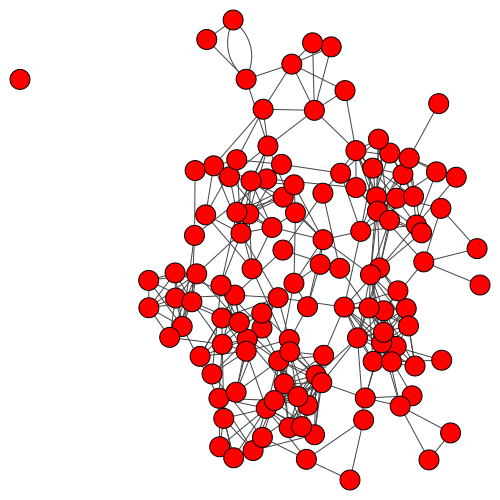

In [10]:
plot(g, bbox = (500,500), margin = 20,layout = g.layout("kk"))

In [12]:
greedy(g, 3, 0.15, mc=100)

([37, 21, 9],
 [30.0, 44.0, 52.0],
 [6.8662450313568115, 16.678515195846558, 30.512377977371216])